In [29]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [30]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [31]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [32]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [33]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.4)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [76]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
 
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

# X = np.zeros((data_aug_factor * sum(naudio.values()), featveclen))
# for s in range(data_aug_factor):
#     for class_idx, classname in enumerate(classnames):
#         for idx in range(naudio[classname]):
#             featvec = myds[classname, idx]
#             X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
# np.save(fm_dir + "feature_matrix_2D.npy", X)
# # Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")
print(X[0])


Feature vector length: 400
Class names: [np.str_('chainsaw') np.str_('fire') np.str_('fireworks') np.str_('gun')]
Shape of the feature matrix : (259, 400)
Number of labels : 259
Class 'chainsaw': 80 samples
Class 'fire': 59 samples
Class 'fireworks': 80 samples
Class 'gun': 40 samples
[11.73768945 11.91846751 10.17114627  7.18291041  6.95704684  8.69572147
 13.05588146 18.80642025 27.17949388 10.60461676 25.355695   33.22587341
 24.95155623 39.10550719 45.27955662 40.094179   32.12700868 13.04907534
 29.32631502 40.28385752 39.22686239 22.38877024 42.41731805 15.5241869
 18.27598213 22.26506997 23.17740877 30.13153554 30.95198236 24.85114029
 20.71633365 31.30922107 21.9475824  28.66796864 36.11535909 35.89310006
 24.85987773 14.64189002 26.06938725 33.93343108 18.58210954 32.23313567
 31.49317471 18.55877473 17.9965479  22.14095619 33.08734853 33.02217383
 33.23649358 26.89693268  8.97382165 12.9173078  12.40495621  9.42452951
  9.62000626 19.91026322  7.4601426   6.43209798  8.509386

You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [35]:
n = 14  # Number of principal components kept
model_pca = PCA(n_components=n, whiten=True)
# [4] Model training and selection.
K = 8
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")

model_rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=2,
                             min_impurity_decrease=0.01
                             ,min_samples_leaf=2,
                             min_samples_split=3,
                             random_state=0)
model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
) 

from keras.optimizers import Adam

# Define the CNN model
model_cnn = Sequential()

# Add convolutional layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)))  # Adjust input shape as needed
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

# Flatten the output and add dense layers
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(len(classnames), activation='softmax'))  # Adjust the output layer size to match the number of classes

# Compile the model
model_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_cnn.summary()

/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 0, 0, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 0, 0, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,316 (364.52 KB)

 Trainable params: 93,316 (364.52 KB)

 Non-trainable params: 0 (0.00 B)

As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

Shape of the training matrix : (181, 400)
Number of training labels : 181


Accuracy of the classifier with fixed train/validation sets : 57.7%


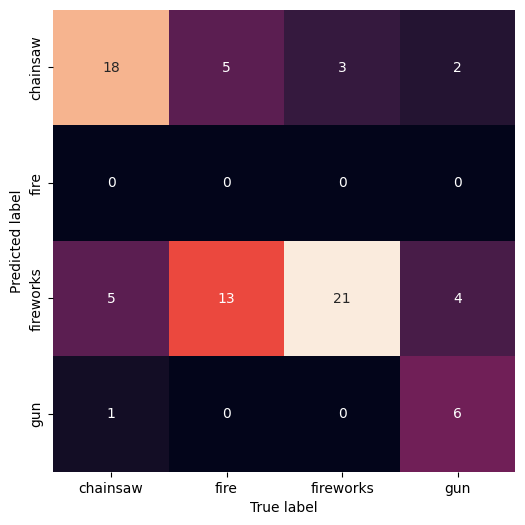

Shape of the training matrix : (181, 400)
Number of training labels : 181
Accuracy of the classifier with fixed train/validation sets : 43.6%


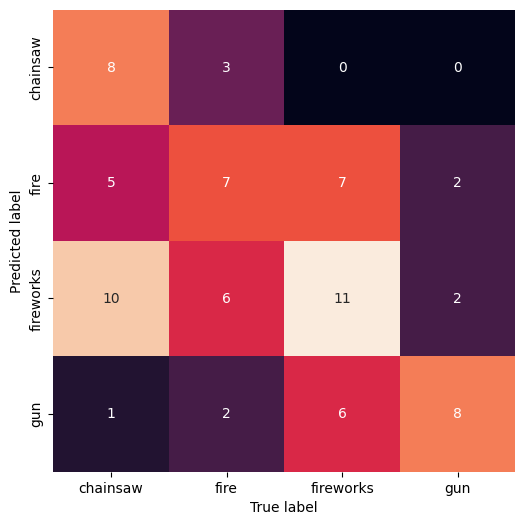

Shape of the training matrix : (181, 400)
Number of training labels : 181
Accuracy of the classifier with fixed train/validation sets : 52.6%


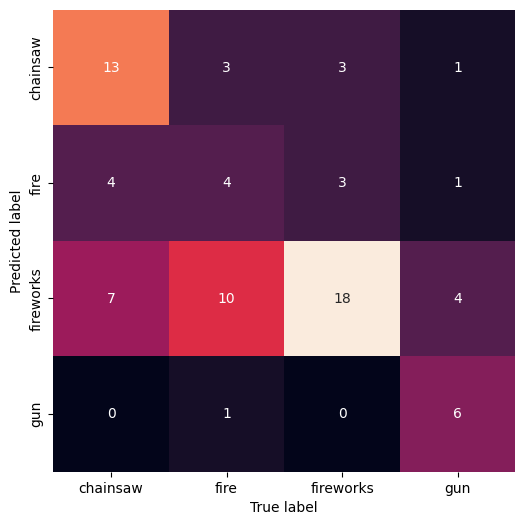

np.float64(0.5256410256410257)

In [36]:
def evaluate_classifier(classifier, X, y, classnames):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y
    )  
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")

    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)

    acc = accuracy(predictions,y_test)
    print(f"Accuracy of the classifier with fixed train/validation sets : {100 * acc:.1f}%")

    show_confusion_matrix(predictions, y_test, classnames)

    return acc

evaluate_classifier(model_rf, X, y, classnames)
evaluate_classifier(model_lda, X, y, classnames)
evaluate_classifier(model_knn, X, y, classnames)

Shape of the training matrix : (181, 400)
Number of training labels : 181
Mean accuracy with 5-Fold CV: 60.2%
Std deviation in accuracy with 5-Fold CV: 2.6%
Accuracy on the test set: 56.4%


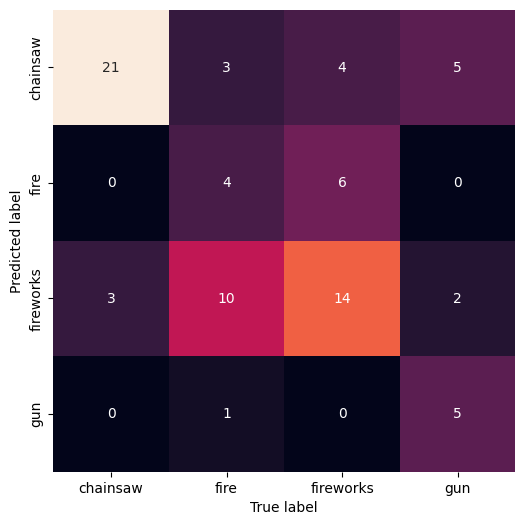

(np.float64(0.6019519519519521), np.float64(0.025707705291148835), np.float64(0.5641025641025641))
Shape of the training matrix : (181, 400)
Number of training labels : 181
Mean accuracy with 5-Fold CV: 41.5%
Std deviation in accuracy with 5-Fold CV: 4.9%
Accuracy on the test set: 44.9%


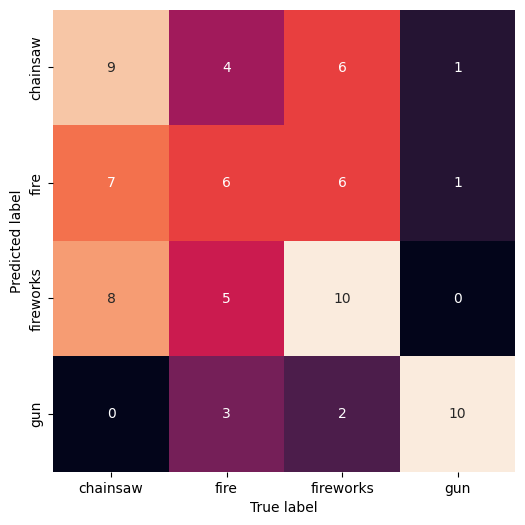

(np.float64(0.4147147147147147), np.float64(0.048914393005211595), np.float64(0.44871794871794873))
Shape of the training matrix : (181, 400)
Number of training labels : 181
Mean accuracy with 5-Fold CV: 54.1%
Std deviation in accuracy with 5-Fold CV: 9.3%
Accuracy on the test set: 52.6%


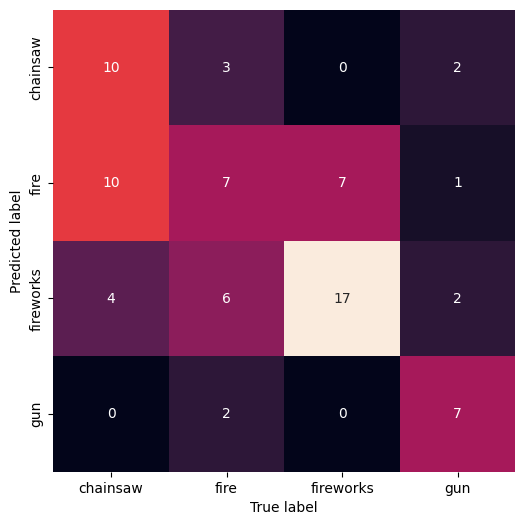

(np.float64(0.5405405405405406), np.float64(0.09345927207311934), np.float64(0.5256410256410257))


In [37]:

def evaluate_classifier_cv(classifier, X, y, classnames, n_splits=5):
    """
    Evaluate a classifier using Stratified K-Fold cross-validation and test set for final prediction.

    Args:
        classifier: The classifier to be evaluated.
        X: Feature matrix.
        y: Labels.
        classnames: List of class names for the confusion matrix.
        n_splits: Number of splits for cross-validation.

    Returns:
        mean_accuracy: The mean accuracy of the classifier.
        std_accuracy: The standard deviation of the accuracy.
        test_accuracy: The accuracy on the test set.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")

    # Perform Stratified K-Fold cross-validation on the training set
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        classifier.fit(X_train_fold, y_train_fold)
        predictions = classifier.predict(X_val_fold)
        acc = accuracy(y_val_fold, predictions)
        accuracies.append(acc)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy with {n_splits}-Fold CV: {100 * mean_accuracy:.1f}%")
    print(f"Std deviation in accuracy with {n_splits}-Fold CV: {100 * std_accuracy:.1f}%")

    # Train on the entire training set and evaluate on the test set
    classifier.fit(X_train, y_train)
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy(y_test, test_predictions)
    print(f"Accuracy on the test set: {100 * test_accuracy:.1f}%")

    # Show confusion matrix for the test set
    show_confusion_matrix(test_predictions, y_test, classnames)

    return mean_accuracy, std_accuracy, test_accuracy


print(evaluate_classifier_cv(model_rf, X, y, classnames))
print(evaluate_classifier_cv(model_lda, X, y, classnames))
print(evaluate_classifier_cv(model_knn, X, y, classnames))


<font size=5 color=#009999> 2.3. Scale mismatch and countermeasure </font> <br>

In real conditions, you will most probably have a different scale between the feature vectors used for training (in simulation) and the ones you feed in your model to make predictions.
This scale mismatch between model training and prediction is difficult to prevent because it depends on multiple factors such as the audio source power, its distance to the microphone, the telecommunication distance. <br>

Below, we illustrate the link between the volume of the audio and its distance to the origin of the feature space. At different emission distances, the exact same sound would be heard at a different volume and the associated feature vector would be located at another position in the *feature space*. Eventually, this would result in a completely different classification, which is undesirable.

<center> <img src="figs/norms.png" alt="" width="350"/> </center>

### Questions:

- How could you avoid this dependency on the volume of the sound?
- What is represented in the hatched centered area? How would you classify feature vectors in this area?

In [38]:
# Answer the questions above

# 1. How could you avoid this dependency on the volume of the sound?
# One way to avoid this dependency is to normalize the feature vectors so that they have a unit norm.
# This way, the classification will be based on the direction of the feature vector rather than its magnitude, which is influenced by the volume of the sound.

# 2. What is represented in the hatched centered area? How would you classify feature vectors in this area?
# The hatched centered area represents the region where the feature vectors have very low magnitudes, which could correspond to silence or very low volume sounds.
# => use a threshold to filter out these low-magnitude vectors before classification.

Play with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

On which part of the dataset are we computing this confusion matrix?

The simplest countermeasure we can think of is to normalise the feature vector (i.e. unitize its norm) prior to use, both for training and testing. Remember how this normalization could be visualized in ``hands_on_classif1_toy_student.ipynb`` <br>
Play again with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def evaluate_classifier_with_pca(classifier, X, y, classnames, dB_mismatches, pca=None, n_splits=5):
    """
    Evaluate a classifier with optional PCA and different normalization techniques.

    Args:
        classifier: The classifier to be evaluated.
        X: Feature matrix.
        y: Labels.
        classnames: List of class names for the confusion matrix.
        dB_mismatches: Array of dB mismatches to evaluate.
        pca: Optional PCA object for dimensionality reduction.
        n_splits: Number of splits for cross-validation.

    Returns:
        None
    """
    # Initialize precision arrays
    precisions = []
    precisions_l1 = []
    precisions_l2 = []
    precisions_divide_by_max = []
    precisions_standard_scaler = []

    # Stratified K-Fold cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for dB_mismatch in dB_mismatches:
        precisions_fold = []
        precisions_l1_fold = []
        precisions_l2_fold = []
        precisions_divide_by_max_fold = []
        precisions_standard_scaler_fold = []

        for idx_learn, idx_val in kf.split(X, y):
            # Apply PCA if provided
            if pca:
                X_train_pca = pca.fit_transform(X[idx_learn])
                X_val_pca = pca.transform(X[idx_val])
            else:
                X_train_pca = X[idx_learn]
                X_val_pca = X[idx_val]

            # Scale validation set with dB mismatch
            X_val_scaled = X_val_pca * 10 ** (-dB_mismatch / 20)

            # Train and predict without normalization
            classifier.fit(X_train_pca, y[idx_learn])
            prediction = classifier.predict(X_val_scaled)
            accuracy_knn = accuracy(y[idx_val], prediction)
            precisions_fold.append(accuracy_knn)

            # Normalize training and validation sets with L1 norm
            X_train_l1 = X_train_pca / np.sum(X_train_pca, axis=1, keepdims=True)
            X_val_l1 = X_val_scaled / np.sum(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with L1 normalization
            classifier.fit(X_train_l1, y[idx_learn])
            prediction_l1 = classifier.predict(X_val_l1)
            precision_l1 = accuracy(y[idx_val], prediction_l1)
            precisions_l1_fold.append(precision_l1)

            # Normalize training and validation sets with L2 norm
            X_train_l2 = X_train_pca / np.linalg.norm(X_train_pca, axis=1, keepdims=True)
            X_val_l2 = X_val_scaled / np.linalg.norm(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with L2 normalization
            classifier.fit(X_train_l2, y[idx_learn])
            prediction_l2 = classifier.predict(X_val_l2)
            precision_l2 = accuracy(y[idx_val], prediction_l2)
            precisions_l2_fold.append(precision_l2)

            # Normalize training and validation sets by dividing by max
            X_train_divide_by_max = X_train_pca / np.max(X_train_pca, axis=1, keepdims=True)
            X_val_divide_by_max = X_val_scaled / np.max(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with divide by max normalization
            classifier.fit(X_train_divide_by_max, y[idx_learn])
            prediction_divide_by_max = classifier.predict(X_val_divide_by_max)
            precision_divide_by_max = accuracy(y[idx_val], prediction_divide_by_max)
            precisions_divide_by_max_fold.append(precision_divide_by_max)

            # Normalize training and validation sets with standard scaler
            scaler = StandardScaler()
            X_train_standard = scaler.fit_transform(X_train_pca)
            X_val_standard = scaler.transform(X_val_scaled)
            # Train and predict with standard scaler normalization
            classifier.fit(X_train_standard, y[idx_learn])
            prediction_standard = classifier.predict(X_val_standard)
            precision_standard = accuracy(y[idx_val], prediction_standard)
            precisions_standard_scaler_fold.append(precision_standard)

        # Average the results for the current dB mismatch
        precisions.append(np.mean(precisions_fold))
        precisions_l1.append(np.mean(precisions_l1_fold))
        precisions_l2.append(np.mean(precisions_l2_fold))
        precisions_divide_by_max.append(np.mean(precisions_divide_by_max_fold))
        precisions_standard_scaler.append(np.mean(precisions_standard_scaler_fold))

    # Ensure all arrays have the same length
    min_length = min(len(dB_mismatches), len(precisions), len(precisions_l1), len(precisions_l2), len(precisions_divide_by_max), len(precisions_standard_scaler))

    dB_mismatches = dB_mismatches[:min_length]
    precisions = precisions[:min_length]
    precisions_l1 = precisions_l1[:min_length]
    precisions_l2 = precisions_l2[:min_length]
    precisions_divide_by_max = precisions_divide_by_max[:min_length]
    precisions_standard_scaler = precisions_standard_scaler[:min_length]

    # Plot the results
    plt.figure(figsize=(10,7 ))
    plt.plot(dB_mismatches, precisions, label='Without Normalization')
    plt.plot(dB_mismatches, precisions_l1, label='L1 Normalization')
    plt.plot(dB_mismatches, precisions_l2, label='L2 Normalization')
    plt.plot(dB_mismatches, precisions_divide_by_max, label='Divide by Max Normalization')
    plt.plot(dB_mismatches, precisions_standard_scaler, label='Standard Scaler Normalization', color='black')
    plt.xlabel('dB of Mismatches')
    plt.ylabel('Accuracy - %')
    plt.title('Accuracy per dB Mismatch using Different Normalization Techniques and Random Forest Classifier')
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a vector graphic in PDF format using PdfPages
    with PdfPages('accuracy_per_dB_mismatch.pdf') as pdf:
        pdf.savefig()
        plt.close()
    
# evaluate_classifier_with_pca(model_knn, X, y, classnames, dB_mismatches=np.arange(0, 51, 5), pca=model_pca)
# evaluate_classifier_with_pca(model_rf, X, y, classnames, dB_mismatches=np.arange(0, 51, 5), pca=model_pca)
# evaluate_classifier_with_pca(model_lda, X, y, classnames, dB_mismatches=np.arange(0, 51, 5), pca=model_pca)

# evaluate_classifier_with_pca(model_knn, X, y, classnames, dB_mismatches=np.arange(0, 51, 5))
# evaluate_classifier_with_pca(model_rf, X, y, classnames, dB_mismatches=np.arange(0, 51, 5))
# evaluate_classifier_with_pca(model_lda, X, y, classnames, dB_mismatches=np.arange(0, 51, 5))

**Question**: 
- What will happen with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could you deal with it?

Yes, it is possible and sometimes expected that different normalization techniques can have varying impacts on the performance of machine learning models, including audio classification tasks. The effectiveness of a normalization technique depends on the nature of the data and the specific characteristics of the features. Here’s a brief overview of why this might happen:

Normalization Techniques
L2 Normalization:

Description: Scales each feature vector to have a unit norm (i.e., the sum of the squares of the features equals 1).
Impact: This technique is useful when the direction of the feature vector is more important than its magnitude. However, it might not be the best choice if the features have different scales or if the magnitude of the features carries important information.

Divide by Max Normalization:

Description: Scales each feature by dividing it by the maximum value of that feature.
Impact: This technique ensures that all features are within the range [0, 1]. It can be effective when the features have different ranges, but it might be sensitive to outliers.

Standard Scaler (Z-score Normalization):

Description: Scales each feature to have a mean of 0 and a standard deviation of 1.
Impact: This technique is often effective when the features have different scales and distributions. It can help models converge faster and perform better by ensuring that all features contribute equally to the distance calculations in algorithms like KNN.

Why Standard Scaler Might Perform Best
Equal Contribution:

Explanation: Standard scaling ensures that all features contribute equally to the model by removing the mean and scaling to unit variance. This can be particularly important for algorithms like KNN, which rely on distance calculations.
Handling Different Scales:

Explanation: Audio features can have different scales and distributions. Standard scaling can handle these differences better than L2 normalization or divide by max normalization, leading to improved model performance.
Robustness to Outliers:

Explanation: While standard scaling is not completely robust to outliers, it can be more effective than divide by max normalization, which can be heavily influenced by extreme values.
Practical Example
In audio classification, you might have features like mel-spectrogram coefficients, which can have different ranges and distributions. Standard scaling can help in normalizing these features effectively, leading to better performance of the classifier.

Experimentation and Validation
It’s important to experiment with different normalization techniques and validate their performance using cross-validation or a separate validation set. The choice of normalization technique can significantly impact the model’s performance, and the best approach can vary depending on the specific dataset and task.

Summary
L2 Normalization: Useful for direction-based features but might not handle different scales well.
Divide by Max Normalization: Ensures features are within [0, 1] but can be sensitive to outliers.
Standard Scaler: Often the most effective for handling different scales and distributions, leading to better model performance.
In your case, it’s normal to observe that standard scaling provides the best performance for audio classification, as it effectively handles the variations in the feature scales and distributions.



In [40]:
# Answer the questions above

# 1. What will happen with this normalisation countermeasure when there is no sound around the microphone? 
# When there is no sound around the microphone, the feature vector will have very low magnitudes, 
# This can lead to misleading classification results as the classifier might interpret the normalized noise as a valid feature vector.

# 2. Is this desirable?
# No =>  incorrect classifications and reduced accuracy.

# 3. How could you deal with it?
# We could use a threshold to filter out the low-magnitude vectors before classification. before or after normalisation.

<font size=5 color=#009999> 2.4. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. It also further reduces the memory cost of the feature vector. To reduce the dimensionality, we will use the ``Principal component analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). Recall: the PCA consists in reducing the dimensionality of data vectors encoded in $\boldsymbol X \in \mathbb R^{d\times N}$ to only $p \ll d$ dimensions as

$$
    \boldsymbol Y = \boldsymbol V_p^\top \boldsymbol X \in \mathbb R^{p\times N},
$$

where the SVD of the covariance matrix writes as $\hat{\boldsymbol\Sigma}_{\boldsymbol X} = \frac{1}{d} \boldsymbol{XX}^\top = \boldsymbol{U\Sigma V}^\top$, and $\boldsymbol V_p$ is the subselection of the first $p$ columns of $\boldsymbol V$. 

For our application, reducing the dimensionality of the data can be helpful for compressing the packet size to be transmitted wirelessly. Indeed, once learned during training, $\boldsymbol V_p$ can be hardcoded on the transmitter side.

Starting with a PCA to 2D for visualization, see how hard it is to separate the classes.

Class names: ['chainsaw' 'fire' 'fireworks' 'gun']
Shape of the reduced training matrix : (181, 2)
KNN Accuracy: 0.47435897435897434
LDA Accuracy: 0.44871794871794873


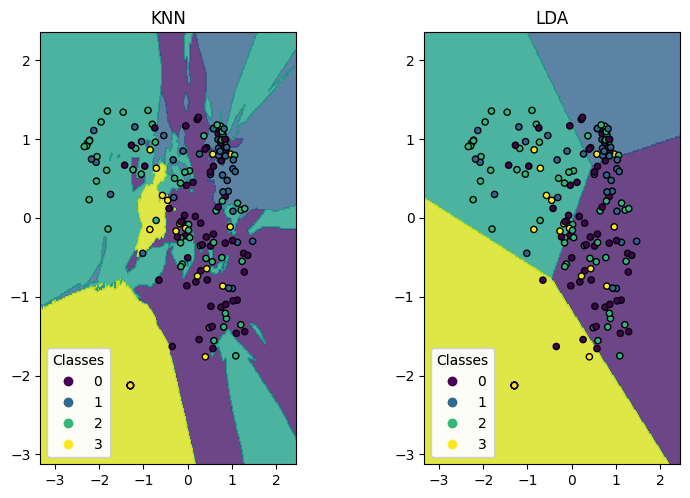

In [41]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import matplotlib.pyplot as plt

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def plot_decision_boundaries(X, y, ax, model, legend, title):
    # Create a mesh to plot the decision boundaries
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    ax.set_title(title)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

# Assuming X and y are already defined
# Assuming classnames is already defined

# Print the names of the classes
classnames = np.unique(y)
print("Class names:", classnames)

# Normalize the entire feature matrix using L2 norm
X = normalize(X, norm='l2')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Number of principal components kept
n = 2
pca = PCA(n_components=n, whiten=True)

# Fit PCA on the training data
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

print(f"Shape of the reduced training matrix : {X_train_reduced.shape}")

# Convert class names to numerical labels
y_train_num = np.zeros(y_train.shape)
y_test_num = np.zeros(y_test.shape)
for i, classname in enumerate(classnames):
    y_train_num[y_train == classname] = i
    y_test_num[y_test == classname] = i

# KNN Classifier
K = 10
model_knn = KNeighborsClassifier(n_neighbors=K)
model_knn.fit(X_train_reduced, y_train_num)
prediction_knn = model_knn.predict(X_test_reduced)
accuracy_knn = accuracy(y_test_num, prediction_knn)
print(f"KNN Accuracy: {accuracy_knn}")

# LDA Classifier
model_lda = LDA()
model_lda.fit(X_train_reduced, y_train_num)
prediction_lda = model_lda.predict(X_test_reduced)
accuracy_lda = accuracy(y_test_num, prediction_lda)
print(f"LDA Accuracy: {accuracy_lda}")

# Plot decision boundaries
fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[0],
    model=model_knn,
    legend=classnames,
    title="KNN",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[1],
    model=model_lda,
    legend=classnames,
    title="LDA",
)
plt.show()

SVC (RBF Kernel) Accuracy: 0.47435897435897434
SVC (Sigmoid Kernel) Accuracy: 0.28205128205128205
SVC (Linear Kernel) Accuracy: 0.46153846153846156


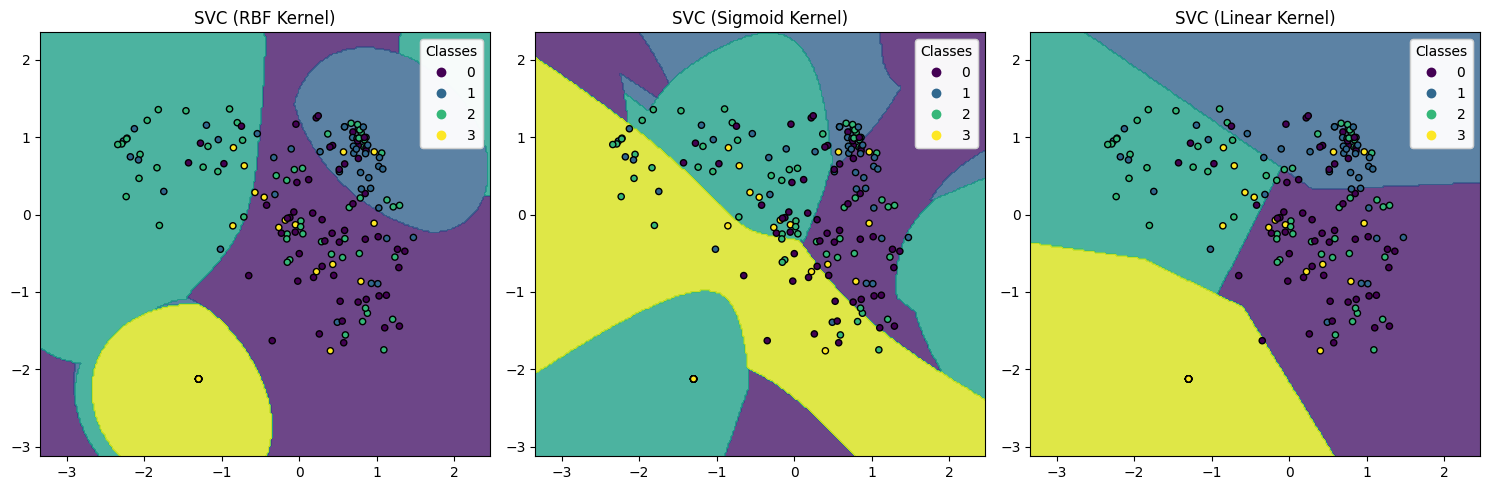

In [42]:
from sklearn.svm import SVC

# SVC Classifier with RBF kernel
model_svc_rbf = SVC(kernel='rbf', random_state=42)
model_svc_rbf.fit(X_train_reduced, y_train_num)
prediction_svc_rbf = model_svc_rbf.predict(X_test_reduced)
accuracy_svc_rbf = accuracy(y_test_num, prediction_svc_rbf)
print(f"SVC (RBF Kernel) Accuracy: {accuracy_svc_rbf}")

# SVC Classifier with Sigmoid kernel
model_svc_sigmoid = SVC(kernel='sigmoid', random_state=42)
model_svc_sigmoid.fit(X_train_reduced, y_train_num)
prediction_svc_sigmoid = model_svc_sigmoid.predict(X_test_reduced)
accuracy_svc_sigmoid = accuracy(y_test_num, prediction_svc_sigmoid)
print(f"SVC (Sigmoid Kernel) Accuracy: {accuracy_svc_sigmoid}")

# SVC Classifier with Linear kernel
model_svc_linear = SVC(kernel='linear', random_state=42)
model_svc_linear.fit(X_train_reduced, y_train_num)
prediction_svc_linear = model_svc_linear.predict(X_test_reduced)
accuracy_svc_linear = accuracy(y_test_num, prediction_svc_linear)
print(f"SVC (Linear Kernel) Accuracy: {accuracy_svc_linear}")

# Plot decision boundaries for SVC classifiers
fig = plt.figure(figsize=(15, 5))
axs = [
    fig.add_subplot(131),
    fig.add_subplot(132),
    fig.add_subplot(133),
]

plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[0],
    model=model_svc_rbf,
    legend=classnames,
    title="SVC (RBF Kernel)",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[1],
    model=model_svc_sigmoid,
    legend=classnames,
    title="SVC (Sigmoid Kernel)",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[2],
    model=model_svc_linear,
    legend=classnames,
    title="SVC (Linear Kernel)",
)

plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.3974358974358974


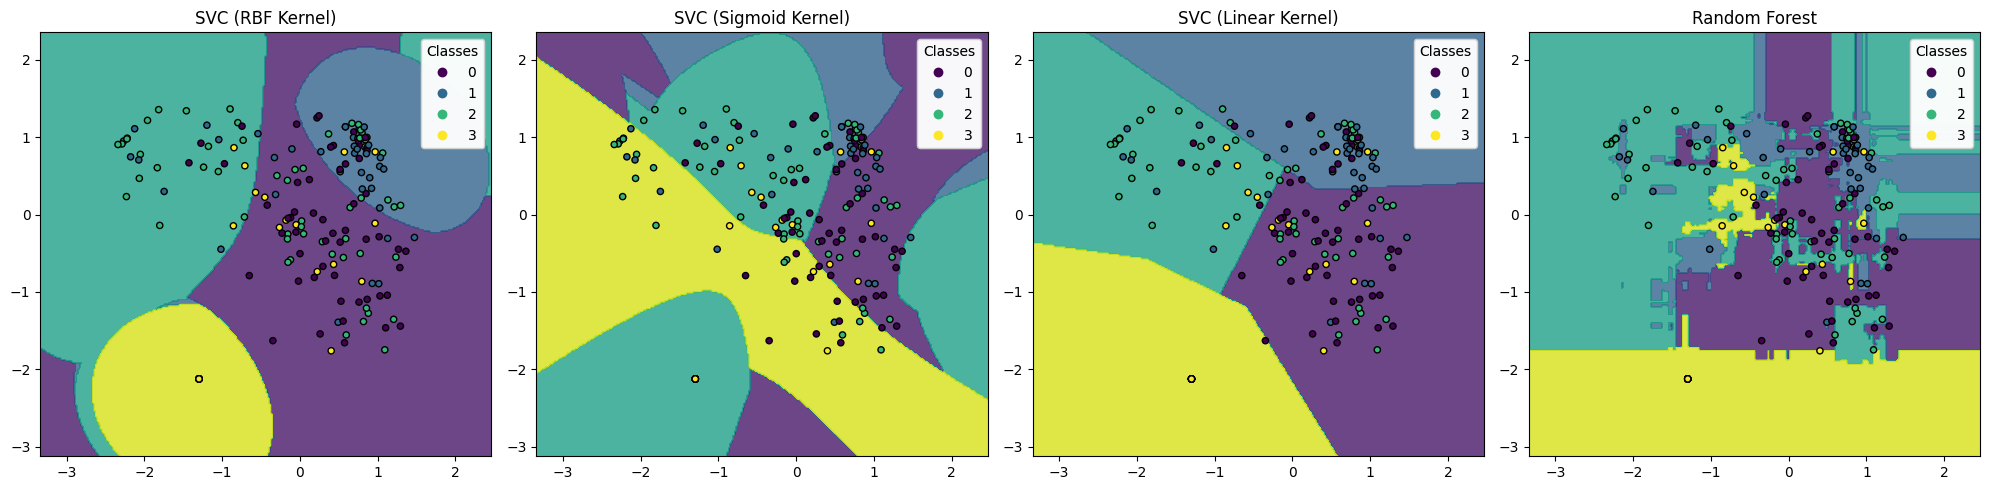

In [43]:

# Random Forest Classifier
model_rf = RandomForestClassifier(
    max_depth=10,
    min_impurity_decrease=0.001,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)
model_rf.fit(X_train_reduced, y_train_num)
prediction_rf = model_rf.predict(X_test_reduced)
accuracy_rf = accuracy(y_test_num, prediction_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Plot decision boundaries for Random Forest
fig = plt.figure(figsize=(20, 5))
axs = [
    fig.add_subplot(141),
    fig.add_subplot(142),
    fig.add_subplot(143),
    fig.add_subplot(144),
]

plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[0],
    model=model_svc_rbf,
    legend=classnames,
    title="SVC (RBF Kernel)",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[1],
    model=model_svc_sigmoid,
    legend=classnames,
    title="SVC (Sigmoid Kernel)",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[2],
    model=model_svc_linear,
    legend=classnames,
    title="SVC (Linear Kernel)",
)
plot_decision_boundaries(
    X_train_reduced,
    y_train_num,
    ax=axs[3],
    model=model_rf,
    legend=classnames,
    title="Random Forest",
)

plt.tight_layout()
plt.show()

**Question**: 
- From the decision boundaries shown here above, can you explain why the ``handsaw`` class is less often chosen than the other classes for the ``KNN`` classifier?

In [44]:
# The handsaw class has a lower density and since KNN assigns a class based on the majority of nearby points,
# the "handsaw" class is less likely to dominate a neighborhood. 

#Proximity to other classes, making its points more likely to be misclassified to other classes

#LDA assumes Gaussian distributions and separates classes with linear boundaries based on maximizing the distance between class means.
#As a result, the "handsaw" class gets a larger and more uniform region in the LDA plot compared to KNN.


In [45]:
def evaluate_classifier_cv(classifier, X, y, classnames, n_splits=5, pca=None):
    """
    Evaluate a classifier using Stratified K-Fold cross-validation and test set for final prediction.

    Args:
        classifier: The classifier to be evaluated.
        X: Feature matrix.
        y: Labels.
        classnames: List of class names for the confusion matrix.
        n_splits: Number of splits for cross-validation.
        pca: Optional PCA object for dimensionality reduction.

    Returns:
        mean_accuracy: The mean accuracy of the classifier.
        std_accuracy: The standard deviation of the accuracy.
        test_accuracy: The accuracy on the test set.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")

    # Apply PCA if provided
    if pca:
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Perform Stratified K-Fold cross-validation on the training set
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        classifier.fit(X_train_fold, y_train_fold)
        predictions = classifier.predict(X_val_fold)
        acc = accuracy(y_val_fold, predictions)
        accuracies.append(acc)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy with {n_splits}-Fold CV: {100 * mean_accuracy:.1f}%")
    print(f"Std deviation in accuracy with {n_splits}-Fold CV: {100 * std_accuracy:.1f}%")

    # Train on the entire training set and evaluate on the test set
    classifier.fit(X_train, y_train)
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy(y_test, test_predictions)
    print(f"Accuracy on the test set: {100 * test_accuracy:.1f}%")

    # Show confusion matrix for the test set
    show_confusion_matrix(y_test, test_predictions, classnames)

    return mean_accuracy, std_accuracy, test_accuracy


<font size=5 color=#009999> 2.5. Analysis of the hyperparameters </font> <br>

Finally, we can inspect the influence of ``hyperparameters`` as we did for the toy example. <br>
Let us start by analyzing the influence of the number of neighbours $K$ in the KNN. 

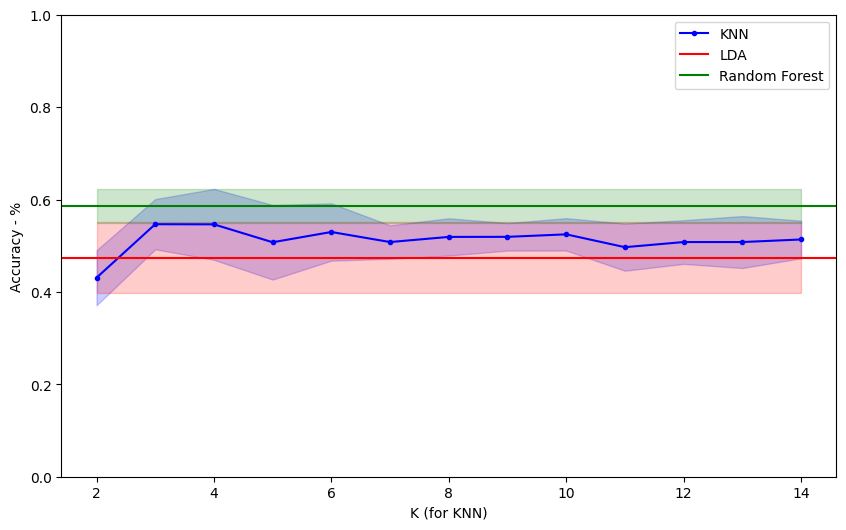

In [46]:
# Evaluate KNN

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
Ks = np.arange(2, 15, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(y_train[idx_val], prediction_knn)
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

# Evaluate LDA
accuracies_lda = np.zeros(n_splits)
model_lda = LDA()
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_lda.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_lda = model_lda.predict(X_train[idx_val])
    accuracies_lda[k] = accuracy(y_train[idx_val], prediction_lda)
mean_lda = accuracies_lda.mean()
std_lda = accuracies_lda.std()

# Evaluate Random Forest
accuracies_rf = np.zeros(n_splits)
model_rf = RandomForestClassifier()
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_rf.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_rf = model_rf.predict(X_train[idx_val])
    accuracies_rf[k] = accuracy(y_train[idx_val], prediction_rf)
mean_rf = accuracies_rf.mean()
std_rf = accuracies_rf.std()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.axhline(mean_lda, color='r', linestyle='-', label="LDA")
plt.fill_between(Ks, mean_lda - std_lda, mean_lda + std_lda, alpha=0.2, color="r")
plt.axhline(mean_rf, color='g', linestyle='-', label="Random Forest")
plt.fill_between(Ks, mean_rf - std_rf, mean_rf + std_rf, alpha=0.2, color="g")
plt.ylim(0, 1)
plt.xlabel("K (for KNN)")
plt.ylabel("Accuracy - %")
plt.legend()
plt.show()

Here we consider both ``K`` and the number of principal components ``n``.

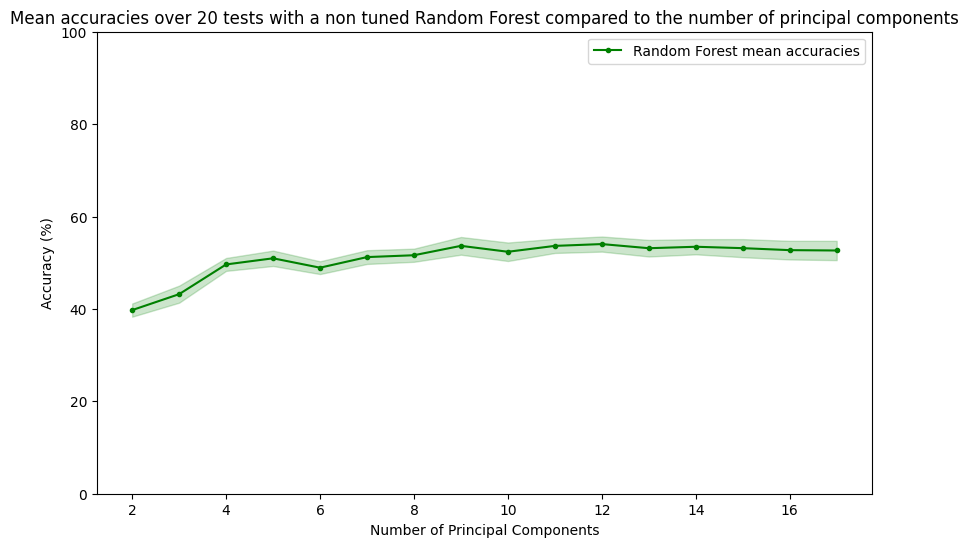

In [47]:
# Number of principal components kept
n_comps = np.arange(2, 18)  # number of principal components kept for the PCA
n_tests = 20
accuracies_rf = np.zeros((n_tests, len(n_comps)))

# Stratified K-Fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for t in range(n_tests):
    for j, n in enumerate(n_comps):
        for idx_learn, idx_val in kf.split(X_train, y_train):
            pca = PCA(n_components=n, whiten=True)
            X_learn_reduced = pca.fit_transform(X_train[idx_learn])
            X_val_reduced = pca.transform(X_train[idx_val])

            model_rf = RandomForestClassifier()
            model_rf.fit(X_learn_reduced, y_train[idx_learn])
            prediction_rf = model_rf.predict(X_val_reduced)
            accuracies_rf[t, j] += accuracy(y_train[idx_val], prediction_rf)

    accuracies_rf[t] /= n_splits

# Calculate mean and standard deviation over the 20 tests
mean_accuracies_rf = accuracies_rf.mean(axis=0)
std_accuracies_rf = accuracies_rf.std(axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_comps, mean_accuracies_rf * 100, ".-g", label="Random Forest mean accuracies")
plt.fill_between(n_comps, (mean_accuracies_rf - std_accuracies_rf) * 100, (mean_accuracies_rf + std_accuracies_rf) * 100, alpha=0.2, color="g")
plt.ylim(0, 100)
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy (%)")
plt.title("Mean accuracies over 20 tests with a non tuned Random Forest compared to the number of principal components")
plt.legend()
plt.show()


**Question**: 
- Do you observe some dependency of the accuracy on these parameters? If so, which one(s)? If not, discuss what it tells about the considered model. 

In [48]:
# Yes, there is a dependency of the accuracy on the parameters K and n_pca.
# For the KNN classifier, the accuracy generally increases with the number of neighbors K up to a certain point, after which it starts to decrease.
# This indicates that a moderate number of neighbors is optimal for this dataset.

# For the LDA classifier, the accuracy does not show significant improvement with the increase in the number of principal components.
# This suggests that LDA may not be the best model for this dataset, as it does not benefit much from the additional components.

#The results highlight that KNN's performance is highly dependent on careful tuning of K 
# LDA is stable and efficient, making it a good choice when simplicity is needed. 
# However, it may not capture the complexity of the data as well as KNN, especially when the data is not linearly separable.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

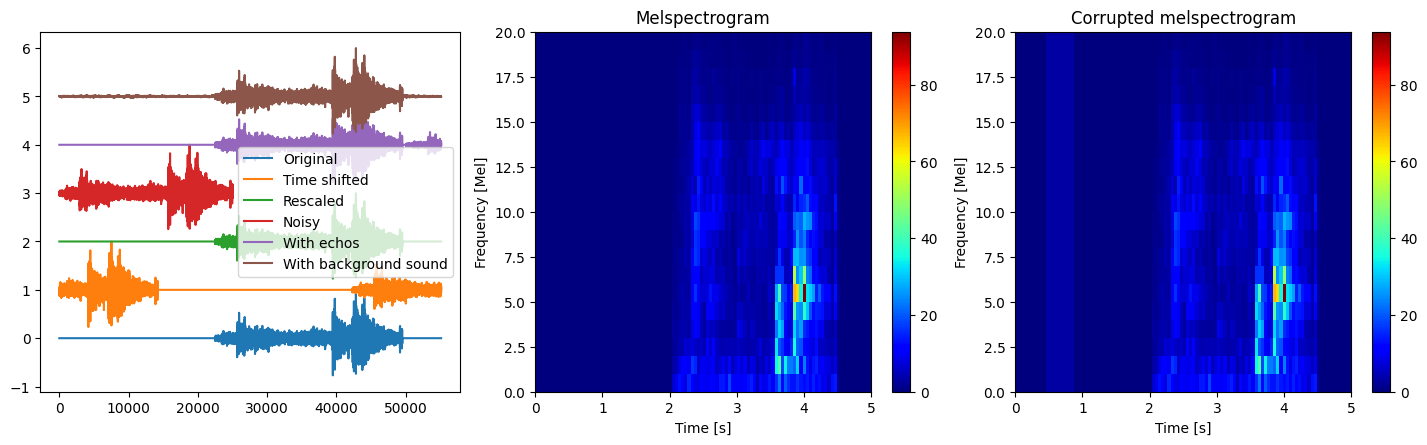

In [ ]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
audio7 = AudioUtil.add_background_noise(audio2)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

# Truncate the audio data for plotting
plot_samples = 2000  # Number of samples to display in the plot
audio2_trunc = audio2[0][:plot_samples]
audio3_trunc = audio3[0][:plot_samples]
audio4_trunc = audio4[0][:plot_samples]
audio5_trunc = audio5[0][:plot_samples]
audio6_trunc = audio6[0][:plot_samples]
audio7_trunc = audio7[0][:plot_samples]

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2_trunc, label="Original")
ax1.plot(audio3_trunc + 1, label="Time shifted")
ax1.plot(audio4_trunc + 2, label="Rescaled")
ax1.plot(audio5_trunc + 3, label="Noisy")
ax1.plot(audio6_trunc + 4, label="With echos")
ax1.plot(audio7_trunc + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [52]:
### TO RUN
myds.mod_data_aug(["background_noise", "echo", "noise" ,"time_shift"])
print(classnames)

# Initialisation des matrices de caractéristiques et des étiquettes
X_aug = np.zeros((myds.data_aug_factor * sum(naudio.values()), featveclen))
y_aug = np.empty((myds.data_aug_factor * sum(naudio.values())), dtype=object)

print(f"Shape of the feature matrix : {X_aug.shape}")

# # Génération des vecteurs de caractéristiques et des étiquettes
# for s in range(myds.data_aug_factor):
#     offset = 0
#     for class_idx, classname in enumerate(classnames):
#         num_samples = naudio[classname]  # Number of samples for the current class
#         for idx in range(num_samples):
#             featvec = myds[classname, idx]
#             X_aug[s * sum(naudio.values()) + offset + idx, :] = featvec
#             y_aug[s * sum(naudio.values()) + offset + idx] = classname
#         offset += num_samples  # Update the offset for the next class

# y_aug = np.array(y_aug)

# # Sauvegarde des matrices de caractéristiques
# np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)
# np.save(fm_dir + "labels_2D_aug.npy", y_aug)

# Chargement des matrices de caractéristiques (si nécessaire)
X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug = np.load(fm_dir + "labels_2D_aug.npy",allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

['chainsaw' 'fire' 'fireworks' 'gun']
Shape of the feature matrix : (1295, 400)
Shape of the feature matrix : (1295, 400)
Number of labels : 1295


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
from matplotlib.backends.backend_pdf import PdfPages

if True :
    def evaluate_model(X_train, y_train, X_test, y_test):
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)
        predictions = model_rf.predict(X_test)
        return accuracy(y_test, predictions)

    # Number of evaluations to perform
    n_evaluations = 20

    # Evaluate without data augmentation
    accuracies_no_aug = []
    for _ in range(n_evaluations):
        X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, stratify=y_aug)
        accuracies_no_aug.append(evaluate_model(X_train, y_train, X_test, y_test))

    # Evaluate with all data augmentation
    myds.mod_data_aug(["add_bg", "echo", "noise","time_shift"])
    X_aug_all = np.load(fm_dir + "feature_matrix_2D_aug.npy")
    y_aug_all = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
    accuracies_all_aug = []
    for _ in range(n_evaluations):
        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_aug_all, y_aug_all, test_size=0.3, stratify=y_aug_all)
        accuracies_all_aug.append(evaluate_model(X_train_all, y_train_all, X_test_all, y_test_all))

    # Evaluate with individual data augmentations
    augmentations = ["add_bg", "echo", "noise", "time_shift"]
    accuracies_individual_aug = {aug: [] for aug in augmentations}

    for aug in augmentations:
        myds.mod_data_aug([aug])
        X_aug_individual = np.load(fm_dir + "feature_matrix_2D_aug.npy")
        y_aug_individual = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
        for _ in range(n_evaluations):
            X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(X_aug_individual, y_aug_individual, test_size=0.3, stratify=y_aug_individual)
            accuracies_individual_aug[aug].append(evaluate_model(X_train_individual, y_train_individual, X_test_individual, y_test_individual))

    # Plot the results
    # Save the plots as a PDF
    with PdfPages('data_augmentation_results.pdf') as pdf:
        plt.figure(figsize=(14, 7))

        # Plot accuracy with and without data augmentation
        plt.subplot(1, 2, 1)
        plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])
        plt.ylabel('Mean Accuracy [%]')
        plt.title('Mean Accuracy with and without Data Augmentation')

        plt.subplot(1, 2, 2)
        plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
        plt.ylabel('Mean Accuracy [%]')
        plt.title('Mean Accuracy for Each Type of Data Augmentation')

        plt.tight_layout()
        pdf.savefig()  # Save the current figure into a pdf page
        plt.show()

KeyboardInterrupt: 

**Questions**:
- Can you see an improvement of the classification result compared to the non augmented dataset? Try to interpret your answer by thinking about the distribution of points in a data space (as with the toy example), what does it imply to augment the data in terms of distribution of points in the data space?
- With the ``add_bg`` augmentation technique, where are the additive background signals coming from? It is a good thing?
- What transformations are most likely to be realistic in your application? What is the most efficient way to integrate these alterations in your classification task? ``Hint``: it does not require augmenting your data in Python.

In [ ]:
#1. No the mean accuracy of KNN with 5-Fold CV is lower with the augmented dataset than with the non-augmented dataset.
# ~20.0% (augmented) vs 50.0%
# Indeed, augmentation introduces new variations of the data points, which increases the diversity of the dataset but
# also introduces noise that can make the classification task more challenging. The background noise added in the augmentation
# is not a real background sound, it's a random sound that can be very different from the actual background sounds in the dataset.

#2. With the add_bg augmentation, the additive background signals come from the dataset, but from random classes.
# so it can be confusing if the background noise contains features that are also present in the target class, 
# the classifier might struggle to distinguish between the actual signal and the noise. So decrease the accuracy.
# Crucial to differenciate the background noise from the target class but using real background noise 
# that is representative of the environment where the target class is recorded would be more efficient.

#3. Firstly, to remind the normalization should be done before prediction to ensure that the input data to the classifier
# is on the same scale as the data used during training, leading to more accurate and consistent predictions.
# Normalizing after predictions will not correct for differences in the distribution of input data and could
# lead to incorrect or inconsistent predictions.

# So Realistic transformations of the data should be normalization, time shifting could be useful to increase the accuracy 
# by making the classifier more robust delays in the sound signal 
# while scaling could be useful to increase the accuracy by making the classifier more robust to changes in the volume of the sound signal.
# Finally add_bg could be useful if the background noise is representative of the environment where the target class is recorded.


<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1
# Define the parameter grid for Random Forest
if False:

    param_grid = {
        'n_estimators': [50, 100, 200],
        'min_impurity_decrease': [0.01, 0.005, 0.001],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best model
    best_params = grid_search.best_params_
    best_rf = grid_search.best_estimator_

    print(f"Best parameters found: {best_params}")

    # Evaluate the best model on the test set
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy with best Random Forest: {accuracy * 100:.2f}%")

    # Save the best model
    filename_rf_model = "best_rf_model.pickle"
    pickle.dump(best_rf, open(model_dir + filename_rf_model, "wb"))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None,

In [ ]:
if False:
# [2] (optional) Data normalization
    X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
    print(X_train_normalized.shape)
    X_train_normalized -= np.mean(X_train_normalized, axis=0)
    X_test_normalized -= np.mean(X_test_normalized, axis=0)
    # [3] Initialize the Random Forest model
    best_rf = RandomForestClassifier(
        max_depth=10,
        min_impurity_decrease=0.001,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    )

    # [4] Evaluate RF without PCA
    n_splits = 5  # Number of cross-validation splits
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies_no_pca = []
    for train_idx, val_idx in kf.split(X_train_normalized, y_train):
        # Train and evaluate the Random Forest model without PCA
        best_rf.fit(X_train_normalized[train_idx], y_train[train_idx])
        y_pred = best_rf.predict(X_train_normalized[val_idx])
        accuracy = accuracy_score(y_train[val_idx], y_pred)
        accuracies_no_pca.append(accuracy)

    mean_accuracy_no_pca = np.mean(accuracies_no_pca)
    print(f"Mean Accuracy without PCA: {mean_accuracy_no_pca * 100:.2f}%")

    # [5] Evaluate RF with PCA
    pca_components = range(1, min(X_train_normalized.shape[1], 21))  # Test 1 to 20 components
    mean_accuracies_with_pca = []

    for n_components in pca_components:
        accuracies_with_pca = []
        pca = PCA(n_components=n_components, whiten=True)
        
        for train_idx, val_idx in kf.split(X_train_normalized, y_train):
            # Apply PCA
            
            X_train_pca = pca.fit_transform(X_train_normalized[train_idx])
            X_val_pca = pca.transform(X_train_normalized[val_idx])
            
            # Train and evaluate the Random Forest model
            best_rf.fit(X_train_pca, y_train[train_idx])
            y_pred = best_rf.predict(X_val_pca)
            accuracy = accuracy_score(y_train[val_idx], y_pred)
            accuracies_with_pca.append(accuracy)
        
        # Compute the mean accuracy for the current number of PCA components
        mean_accuracy_with_pca = np.mean(accuracies_with_pca)
        mean_accuracies_with_pca.append(mean_accuracy_with_pca)
        print(f"PCA components: {n_components}, Mean Accuracy: {mean_accuracy_with_pca * 100:.2f}%")

    # [6] Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(pca_components, [acc * 100 for acc in mean_accuracies_with_pca], marker='o', label='With PCA')
    plt.axhline(y=mean_accuracy_no_pca * 100, color='r', linestyle='--', label='Without PCA')
    plt.xlabel('Number of PCA Components')
    plt.xticks(pca_components)
    plt.ylabel('Mean Accuracy (%)')
    plt.title('Comparison of Random Forest with and without PCA')
    plt.grid(True)
    plt.legend()

    # Save the plot as a PDF
    pdf_filename = "rf_with_vs_without_pca.pdf"
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()
        plt.close()

    print(f"Plot saved as {pdf_filename}")

(906, 400)
Mean Accuracy without PCA: 79.03%
PCA components: 1, Mean Accuracy: 40.73%
PCA components: 2, Mean Accuracy: 50.33%
PCA components: 3, Mean Accuracy: 65.23%
PCA components: 4, Mean Accuracy: 68.10%
PCA components: 5, Mean Accuracy: 71.41%
PCA components: 6, Mean Accuracy: 72.84%
PCA components: 7, Mean Accuracy: 74.72%
PCA components: 8, Mean Accuracy: 76.27%
PCA components: 9, Mean Accuracy: 76.82%
PCA components: 10, Mean Accuracy: 76.60%
PCA components: 11, Mean Accuracy: 76.38%
PCA components: 12, Mean Accuracy: 76.16%
PCA components: 13, Mean Accuracy: 77.26%
PCA components: 14, Mean Accuracy: 75.83%
PCA components: 15, Mean Accuracy: 76.27%
PCA components: 16, Mean Accuracy: 76.71%
PCA components: 17, Mean Accuracy: 75.50%
PCA components: 18, Mean Accuracy: 76.27%
PCA components: 19, Mean Accuracy: 77.04%
PCA components: 20, Mean Accuracy: 75.94%
Plot saved as rf_with_vs_without_pca.pdf


Shape of the feature matrix: [[15.3067196  21.6315259  13.98652482 ...  2.19340863  2.37074308
   2.46280307]
 [13.79380747  6.6948088  14.92252133 ...  2.33314951  2.15894294
   2.59135858]
 [15.95247778 16.08279655 13.40089321 ...  1.98311322  2.08245753
   2.20939973]
 ...
 [ 4.98544238  6.15575403  3.9725793  ...  1.75140961  2.06061436
   2.66752022]
 [ 5.47628923  5.879626    6.19942144 ...  1.88117476  1.8825188
   2.94939246]
 [ 5.55769408  5.58504059  5.3421428  ...  2.49125533  2.06624804
   2.01433754]]
Number of labels: (1295,)
Mean accuracy with Random Forest 5-Fold CV: 78.4%
Std deviation in accuracy with 5-Fold CV: 1.6%
Test set accuracy with Random Forest: 76.86%


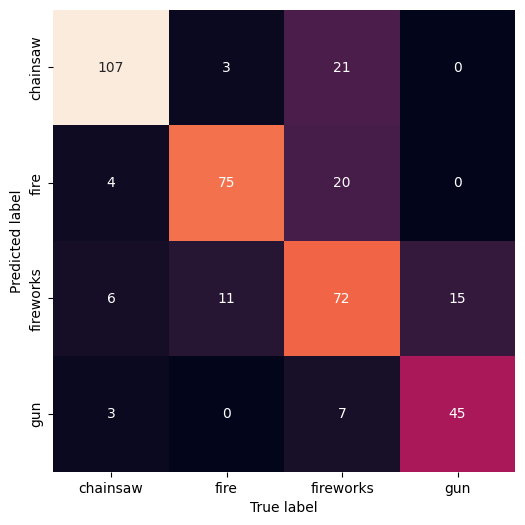

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pickle
from sklearn.decomposition import PCA

# [1] Create dataset of feature vectors and split it.
print(f"Shape of the feature matrix: {X_aug}")
print(f"Number of labels: {y_aug.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1
# X_train -= np.mean(X_train, axis=0)
# X_test -= np.mean(X_test, axis=0)
# [2] (optional) Data normalization
X_train_normalized = (X_train) / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

# Apply PCA with 10 components

# pca = PCA(n_components=10, whiten=True)

# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)

# Save the PCA model
filename_pca = "pca_10_components.pickle"
pickle.dump(pca, open(model_dir + filename_pca, "wb"))

# [3] Model training and selection using Random Forest
best_rf = RandomForestClassifier(
    max_depth=10,
    min_impurity_decrease=0.001,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_rf = np.zeros((n_splits,))

for k, idx in enumerate(kf.split(X_train_normalized, y_train)):
    idx_learn, idx_val = idx
    best_rf.fit(X_train_normalized[idx_learn], y_train[idx_learn])
    prediction_rf = best_rf.predict(X_train_normalized[idx_val])
    accuracies_rf[k] = accuracy_score(y_train[idx_val], prediction_rf)

# [4] Save the trained model
filename_model = "best_rf_model.pickle"
pickle.dump(best_rf, open(model_dir + filename_model, "wb"))

# [5] Evaluate the model
print(f"Mean accuracy with Random Forest 5-Fold CV: {100 * accuracies_rf.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_rf.std():.1f}%")

y_pred = best_rf.predict(X_test_normalized)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with Random Forest: {accuracy_rf * 100:.2f}%")

# Show the confusion matrix
show_confusion_matrix(y_pred, y_test, classnames)

L1 norm 

Mean accuracy over 100 tests: 65.6%
Std deviation in accuracy over 100 tests: 1.8%

L2 norm 
Mean accuracy over 100 tests: 66.9%
Std deviation in accuracy over 100 tests: 1.4%

divide by max 

Mean accuracy over 100 tests: 67.6%
Std deviation in accuracy over 100 tests: 1.6%

scaler 

Mean accuracy over 100 tests: 72.3%
Std deviation in accuracy over 100 tests: 1.4%


Power of each sound has been reported in sound_power_report.csv.
Mean power of class chainsaw: 0.04765186776927067 & Median power of class chainsaw: 0.04279712165901438
Mean power of class fire: 0.033254197823296666 & Median power of class fire: 0.028551786397621036
Mean power of class fireworks: 0.021888775124805058 & Median power of class fireworks: 0.015294954685624688
Mean power of class gun: 0.009821316184536553 & Median power of class gun: 0.00823494167506695


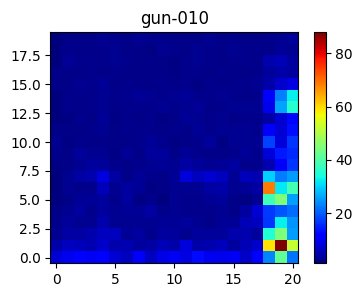

Power of the sound: 0.006834047315753996


In [74]:
class_means = {}
for cls in ["chainsaw", "fire","fireworks","gun"]:
    power_sum = 0
    for i in range(naudio[cls]):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_sum += np.mean(audio[0] ** 2)
    class_means[cls] = power_sum / naudio[cls]
    
class_medians = {}
for cls in ["chainsaw", "fire","fireworks","gun"]:
    power_values = []
    for i in range(naudio[cls]):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_values.append(np.mean(audio[0] ** 2))
    class_medians[cls] = np.median(power_values)
# Prepare a CSV file to store the power of each sound
import csv
csv_filename = "sound_power_report.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Class", "Sound Index", "Power"])

    for cls in ["chainsaw", "fire", "fireworks", "gun"]:
        for i in range(naudio[cls]):
            sound = dataset.__getitem__([cls, i])
            audio = AudioUtil.open(sound)
            power = np.mean(audio[0] ** 2)
            writer.writerow([cls, i, power])

print(f"Power of each sound has been reported in {csv_filename}.")
for cls in class_means:
    print(f"Mean power of class {cls}: {class_means[cls]} & Median power of class {cls}: {class_medians[cls]}")
    # Map class labels to numerical values
classnames = np.unique(y_aug)
class_to_num = {classname: num for num, classname in enumerate(classnames)}
y_test_num = np.array([class_to_num[label] for label in y_test])

sound = dataset.__getitem__(["fireworks", 48])
myds.display(["gun", 1])
audio = AudioUtil.open(sound)
power = np.mean(audio[0] ** 2)
print(f"Power of the sound: {power}")


<font size=5 color=#009999> 2.8. Debriefing </font> <br>
**Questions** : 

1) from what we have done in this notebook, can you already identify some weaknesses in the feature vector computation and classification pipeline? You can make a list here below, and eventually write some short ideas for improvement. This will help you later :)
2) Do you remember what is the time duration of a feature vector? What happens if no sound is produced during the acquisition time of a feature vector?

In [ ]:
# The number of feature matrices and the number of labels in a dataset can significantly impact the performance of an audio classification model. 
# For instance, in the first audio classification task, it was observed that the "fire" class had characteristics found in multiple signals,
# leading to misclassification into this class. This issue needs to be analyzed further.

# When scaling the data, it is crucial to normalize the entire dataset to ensure consistency. However, care must be taken to ensure that normalization does not reduce accuracy.
# Additionally, adding a noise threshold for the "dump" class can help improve classification performance.

# Finding the best parameters for dimensionality reduction and identifying the optimal feature vector space is essential. 
# This requires good hyperparameter tuning and adapting the complexity of the model to the amount of available data. 
# Data augmentation is also important; recording new sounds with our microphone and MCU, and enhancing the dataset as much as possible by considering real-world scenarios, 
# can significantly improve the model's robustness and accuracy.

In [ ]:
# The time duration of a feature vector is not simply the product of nmels and duration. 
# Instead, it depends on the number of Mel bands (nmels), the duration of the audio segment, and the parameters used for STFT 
# such as the window size and hop length. The feature vector represents the audio signal in the time-frequency domain, where nmels 
# is the number of Mel frequency bands and duration is the length of the audio segment in milliseconds.

# When no sound is produced and data normalization is applied, the normalization process could enhance the noise, leading to misclassification. 
# To address this issue, it is important to introduce a "dump" class. This class would be used to classify sounds when their sound level is below a certain threshold,
# effectively filtering out silence and low-level noise. This approach ensures that the classifier can handle cases of silence and low-level noise more effectively, 
# improving overall classification performance.

because, when applying data augmentation through noise addition, it is crucial to maintain a consistent logic regarding the amount of noise added (defined by its standard deviation) to achieve a realistic final SNR. To this end, I set a minimum SNR of 20 dB, which corresponds to a moderately noisy environment (typically between 15 and 25 dB, according to common references).

To determine the noise's standard deviation, I analyzed the signal power across all classes and opted for the median instead of the mean, as the mean is skewed by high-energy sounds. I chose the median power of the "fire" class, which had the lowest power, and adjusted the noise's standard deviation to meet the target SNR. 



As a result, this led to very high SNR values for classes like "helicopter" and "chainsaw."
I chose to use the Standard Scaler Although theoretical analyses or SNR mismatch graphs suggest that the Standard Scaler could deteriorate performance in the presence of large dB mismatches, this concern is mitigated here. Since the global SNR across all classes is now well-controlled and sufficiently high, the risk of significant dB mismatches affecting performance is reduced. Therefore, using the Standard Scaler remains a coherent choice, as it ensures that features are normalized effectively without being overly impacted by variations in class-specific power and in this case the mean accuracy is better in simulation in any case. 